<style>
    @media print{
        body {
            position:relative !important;
        }
        .celltag_new_page {
            page-break-before: always !important;
        }
    }
</style>
# COMPSCI 371 Homework 4
Group Members: Brian Janger, Matthew Wang, Caleb Watson

### Problem 0 (3 points)

In [1]:
from urllib.request import urlretrieve
from os import path as osp


def retrieve(file_name, semester='fall22', course='371', homework=4):
    if osp.exists(file_name):
        print('Using previously downloaded file {}'.format(file_name))
    else:
        fmt = 'https://www2.cs.duke.edu/courses/{}/compsci{}/homework/{}/{}'
        url = fmt.format(semester, course, homework, file_name)
        urlretrieve(url, file_name)
        print('Downloaded file {}'.format(file_name))

In [2]:
for file_name in ('mlp.py', 'checks.py'):
    retrieve(file_name)

Downloaded file mlp.py
Downloaded file checks.py


## Part 1: Line Search

In [3]:
import numpy as np
from matplotlib import pyplot as plt

# defining function
def f(alpha):
    return np.sin((np.pi*alpha + 1)/2)

(a,b,c) = (0,2,5)

### Problem 1.1

Image of the plot - lineplot with red dots as mentioned above
f(0.0) = 0.4794, f(2.0) = -0.4794, f(5.0) = 0.8776


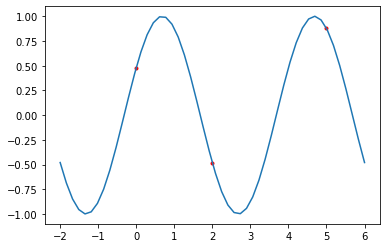

In [4]:
points = [(a, f(a)), (b, f(b)), (c, f(c))]

x = [point[0] for point in points]
y = [point[1] for point in points]
plt.plot(x, y, 'r.')

x_space = np.linspace(-2,6)
y_space = [f(x) for x in x_space]
plt.plot(x_space, y_space, '-')

points = np.round(points, decimals=4)
print("Image of the plot - lineplot with red dots as mentioned above")
print("f({}) = {}, f({}) = {}, f({}) = {}".format(points[0][0], points[0][1], points[1][0], points[1][1], points[2][0], points[2][1]))

### Problem 1.2 (Exam Style)

In order to prove that the triple ($a,b,c$) is a valid bracketing triple, three conditions must be satisfied:  
1) $a < b < c$  
2) $f(a) \geq f(b)$  
3) $f(b) \leq f(c)$. 

As we see above, all conditions are satisfied as $a = 0 < b = 2 < c = 5$, $f(a) = 0.4794 \geq f(b) = -0.4794$, and $f(b) = -0.4794 \leq f(c) = 0.8776$.

### Problem 1.3 (Exam Style)

When finding the values of the bracketing triple ($a',b',c'$) that the line search algorithm immediately computes from the triple given above, the bigger of $[a,b]$ and $[b,c]$ must be determined and then split in half with a point $u$. Given that $c-b = 3$ is larger than $b-a = 2$, we calculate the point $u$ to be $(b+c)/2 = (5+2)/2 = 3.5$. The value of $f(3.5)$, -0.2815, is greater than $f(2)$ and therefore the value of ($a',b',c'$) is ($a,b,u$), or ($0, 2, 3.5$).

### Problem 1.4 (Exam-Style)

If line search is continued from the above values, it will eventually converge at to the local minimum of $f$ at $\alpha = 2.6820$ (where $f(\alpha)=-1$), which is not the closest local minimum to the starting point $\alpha_0 = 0$ (where $\alpha = -1.3180$). The reason why it does not converge to the nearest minimum to $\alpha_0 = 0$ is because the nearest minimum is not in the initial bracketing triple. Line search does not extend its bracket through iterations. Line search will find the local minimum in the bracketing triple. 

The following expression can approximate the numerical value for a point $\alpha^*$ that line search will converge to: $-1/\pi+3$.

## Part 2: Stochastic Gradient Descent 

In [5]:
from mlp import x_digits, y_digits, reset_network, risk_and_gradient, plot_risk_curves

network, z0 = reset_network()

In [6]:
import sklearn

print(sklearn.__version__)

0.24.2


### Problem 2.1

In [7]:
import numpy as np
risk, g_t = risk_and_gradient(z0, x_digits, y_digits, network)

def direction_spread(z, x, y, mlp, batch_size):
    x_batches = [x[i:i + batch_size] for i in range(0, len(x), batch_size)] #split x_digits into batches of batch_size
    y_batches = [y[i:i + batch_size] for i in range(0, len(y), batch_size)] #split y_digits into batches of batch_size
    if(len(x_batches[-1] != batch_size)): x_batches.pop() #remove last batch if not size batch_size
    if(len(y_batches[-1] != batch_size)): y_batches.pop() #remove last batch if not size batch_size 
    
    n = len(x_batches)
    omega_total = 0
    for i in range(0, n): 
        cur_risk, g = risk_and_gradient(z0, x_batches[i], y_batches[i], mlp)
        omega = np.arccos(np.dot(g / np.linalg.norm(g), g_t / np.linalg.norm(g_t))) #compute angle between g and g_t
        omega_total += omega
    omega_average = omega_total / n
    
    print("batch size {}, spread {} degrees".format(batch_size, round(omega_average, 3)))
        
#iterate through batch sizes 
batch_sizes = (5, 10, 20, 50, 100, 200, 500, 1000)
for batch_size in batch_sizes: 
    direction_spread(z0, x_digits, y_digits, network, batch_size)

batch size 5, spread 1.113 degrees
batch size 10, spread 0.916 degrees
batch size 20, spread 0.772 degrees
batch size 50, spread 0.579 degrees
batch size 100, spread 0.425 degrees
batch size 200, spread 0.332 degrees
batch size 500, spread 0.201 degrees
batch size 1000, spread 0.106 degrees


### Problem 2.2

In [8]:
def sgd(z, x, y, mlp,
        n_epochs=5, batch_size=200,
        epoch_alpha=1., record=False):
    rng = np.random.default_rng(0)
    n_samples = len(y)
    # Possibly miss a few data points at the end for simplicity
    n_batches = n_samples // batch_size
    alpha = epoch_alpha / n_batches
    step = 0
    
    if record:
        training_risks = [(step, risk_and_gradient(z, x, y, mlp)[0])]
        batch_risks = []
    else:
        training_risks, batch_risks = None, None
        
    for epoch in range(n_epochs):
        indices = rng.permutation(n_samples)
        b_start, b_stop = 0, batch_size
        
        for b in range(n_batches):
            step += 1
            batch_indices = indices[b_start:b_stop]
            x_batch, y_batch = x[batch_indices], y[batch_indices]
            
            r_batch_before, g = risk_and_gradient(z, x_batch, y_batch, mlp) #calculate risk and g on batch before z updates 
            z = z - (epoch_alpha / n_batches) * g # uses g to update the parameter vector z 
            
            if record: 
                r_batch_after, g = risk_and_gradient(z, x_batch, y_batch, mlp)
                r_training_after, g = risk_and_gradient(z, x, y, mlp)
                batch_risks.append(((step - 1, r_batch_before), (step, r_batch_after)))
                training_risks.append((step, r_training_after))
            
            #update b_start and b_stop 
            b_start += batch_size
            b_stop += batch_size
            
    return z, training_risks, batch_risks

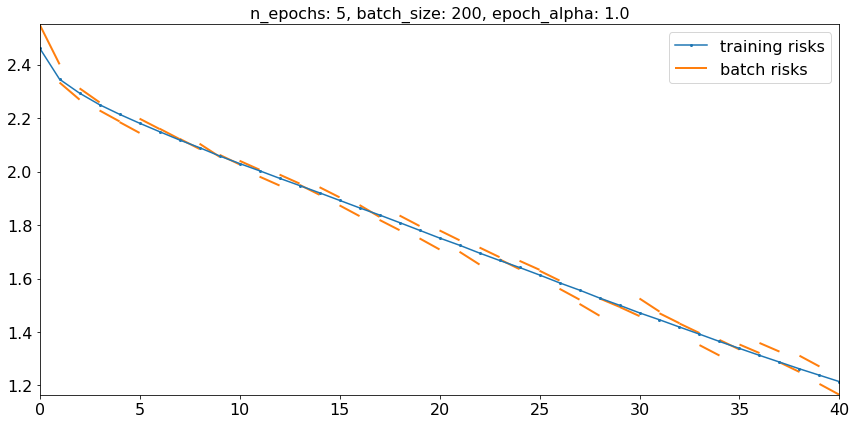

In [9]:
def sgd_experiment(batch_size, epoch_alpha, n_epochs, record):
    network, z0 = reset_network()
    z, training_risks, batch_risks = sgd(z0, x_digits, y_digits, network, n_epochs=n_epochs, batch_size=batch_size, epoch_alpha=epoch_alpha, record=record)
    
    if record: 
        title = "n_epochs: {}, batch_size: {}, epoch_alpha: {}".format(n_epochs, batch_size, epoch_alpha)
        plot_risk_curves(training_risks, batch_risks, title=title, fs=16)
    return z, training_risks, batch_risks

z, training_risks, batch_risks = sgd_experiment(batch_size=200, epoch_alpha=1., n_epochs=5, record=True)

### Problem 2.3 (Exam Style)

- The value of both the training risks and the batch risks are decreasing because by taking steps on each batch, we are decreasing the risk over time on average. 


- However, the batch risk jumps up and down in each step because not every step is optimal since we are only taking a batch sample from the entire training set. However, it is correct on average over time. 

### Problem 2.4 (Exam Style except for Making the Plot)

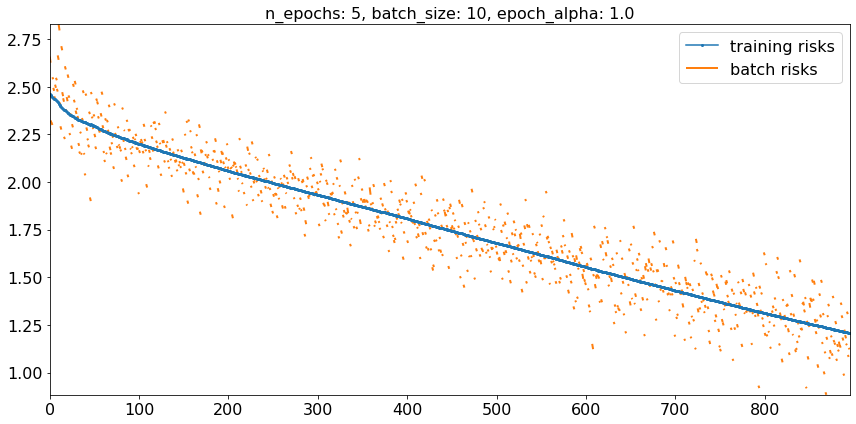

In [10]:
z, training_risks, batch_risks = sgd_experiment(batch_size=10, epoch_alpha=1., n_epochs=5, record=True)

- What is most similar with this plot compared to the batch_size=200 plot is that the training risk curve is about identical, and the end training risk is about the same. In batch_size=10, we are taking much smaller steps, but we are taking a lot more steps. However, these steps are correct on average over time, and we can interpret the training risks graph as the average 


- As for batch risks, we see more variance, because the samples are smaller. A smaller sample leads to less clarity on what the true step direction is. Some steps lead to risk increasing, but these much smaller batch steps are on average correct over a greater number of steps. 

### Problem 2.5 (Exam Style except for Making the Plots)

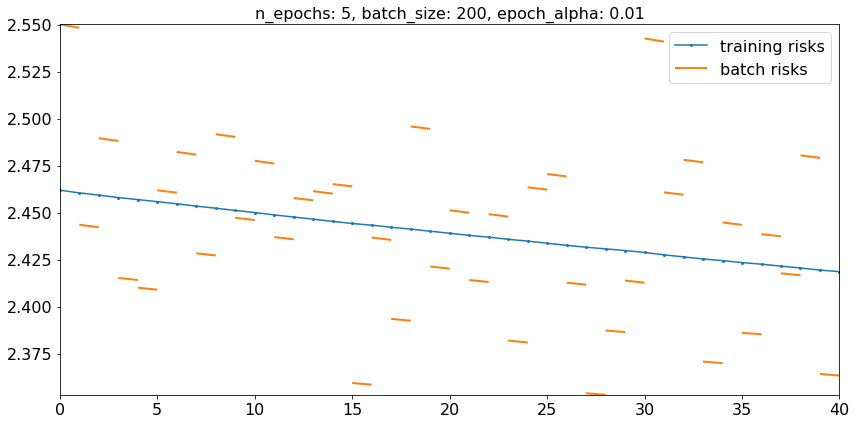

In [11]:
z, training_risks, batch_risks = sgd_experiment(batch_size=200, epoch_alpha=.01, n_epochs=5, record=True)

With a much smaller alpha, we are taking much smaller steps. This means that progress is more steady, but much slower. We see that with such a small alpha, we've only reduced our risk by 0.05. However, the variance between batches is smaller from the mean (it doesn't look like it on the graph, but its true if you scale out). 

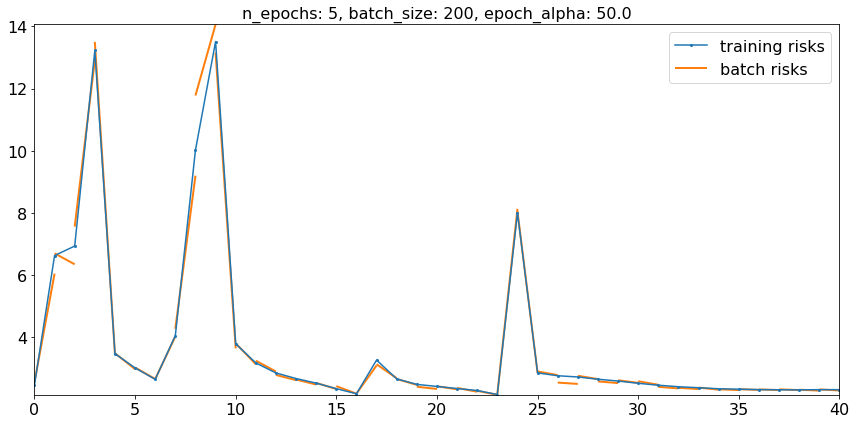

In [12]:
z, training_risks, batch_risks = sgd_experiment(batch_size=200, epoch_alpha=50., n_epochs=5, record=True)

With a very large alpha, we are taking much larger step sizes. However, with large step sizes, batches that point to the wrong direction are amplified, hence why we see the spikes in risk. 

### Problem 2.6  (Exam Style except for Making the Plot)

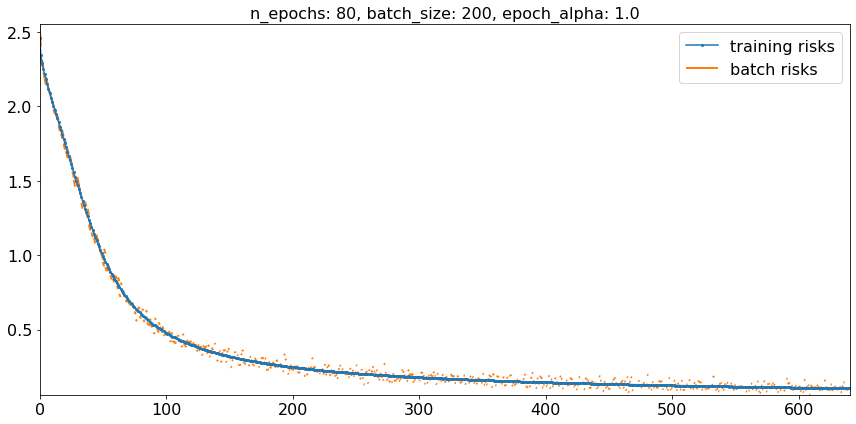

In [13]:
z, training_risks, batch_risks = sgd_experiment(batch_size=200, epoch_alpha=1., n_epochs=80, record=True)

The final predictor is quite accurate as the more steps we take, our risk is gradually approaching 0. It is gauranteed to generalize well, because these smaller batch steps are correct on average over a greater number of steps. 

## Part 3: Hyperplanes

### Problem 3.1 (Exam Style)

1. <br>

We can transform $\tilde{a}$ customarily by transforming it to its normal form. So we can set $a = \frac{\tilde{a}}{\lVert\tilde{a}\rVert}$. This new vector $a$ has the same direction of $\tilde{a}$, but with magnitude 1.

Transforming $\tilde{a}$ to $a$ requires us to transform the vector $\tilde{b}$ to keep the same solution set $z$.

$$\left(\frac{\tilde{a}}{\lVert\tilde{a}\rVert}\right)^Tz = b \Rightarrow \tilde{a}^Tz = b\lVert\tilde{a}\rVert$$

We can see that $\tilde{b} = b\lVert\tilde{a}\rVert$, so $b = \frac{\tilde{b}}{\lVert\tilde{a}\rVert}$.

2. <br>

Since the hyperplane is a line, the only other canonical implicit representation is the opposite direction of the unit vector $a = \frac{\tilde{a}}{\lVert\tilde{a}\rVert}$. In this case, we set $a = -\frac{\tilde{a}}{\lVert\tilde{a}\rVert}$ and $b = -\frac{\tilde{b}}{\lVert\tilde{a}\rVert}$.

3. <br>

We define $p$ to be the point on the hyperplane that's closest to the origin, which can be defined as $p = ab$, where $a$ is the unit vector perpendicular to the hyperplane and $b$ is the distance from the origin to the closest point on the hyperplane, as computed in 3.1.1.

When the hyperplane is a line, $q$ is a vector parallel to the hyperplane (geometrically, $z = p + q\alpha$ shows all points $z$ on the hyperplane by going to $p$, the closest point on the hyperplane to the origin, and going across the line perpendicular to the hyperplane $q$, which is scaled by some scalar $\alpha$.

We know that $a$ is a vector perpendicular to the hyperplane with unit length 1, so $q$ must be a vector perpendicular to $a$. If $a = (a_x, a_y)$ such that $\sqrt{a_x^2 + a_y^2}=1$, then $q = (-a_y, a_x)$. (We can prove these two vectors are perpendicular by taking the dot product of the two vectors, as $(a_x,a_y)\cdot(-a_y,a_x)=0$.)

4. <br>

The only other canonical parametric representation of this line is to take the same point $p$ (as the closest point to the origin on the hyperplane is always the same) and the unit vector $p'$ in the opposite direction of $p$, as this vector still denotes the same line.

So we choose $p = ab$ as before, and $q = (a_y, -a_x)$ where $a = (-a_y, a_x)$.

### Problem 3.2 (Exam Style)

1. <br>

Since we know $\tilde{q}$ must be a vector parallel to the hyperplane, we simply want to transform $\tilde{q}$ into a vector $q$ such that $\lVert q \rVert = 1$. We can do this by setting $q = \frac{\tilde{q}}{\lVert \tilde{q} \rVert}$.

If we write the vector $\tilde{p}$ in its orthogonal decomposition, $\tilde{p} = \tilde{p}_v + \tilde{p}_{v^\perp}$ ($v$ denoting the line of the hyperplane), we can project $\tilde{p}$ onto the line $v$ of the hyperplane to find $\tilde{p}_v$. This is done by saying $\tilde{p}_v = \frac{\tilde{p}\cdot\tilde{q}}{\tilde{q}\cdot\tilde{q}}\tilde{q}$. We know that $\tilde{p}_{v^\perp} = p$, since it denotes the component of the vector $\tilde{p}$ that's perpendicular to the hyperplane. Thus, this vector alone must be $p$, as $p$ itself must be perpendicular to the hyperplane line.

Therefore, $p = \tilde{p} - \tilde{p}_v = \tilde{p} - \frac{\tilde{p}\cdot\tilde{q}}{\tilde{q}\cdot\tilde{q}}\tilde{q}$.

2. <br>

We've already established that $a$ must be a vector perpendicular to the hyperplane. We know that $p$ is a vector perpendicular to the hyperplane (as we've found in 3.2.1), so we can say that $a = \frac{p}{\lVert p \rVert}$.

The equation $a^Tz=b$ tells us that for any vector $z$ that satisfies the equation, the inner product of $a$ and $z$ is the same. Since we know $a$ has unit norm, this tells us that $b$ must represent the shortest distance from the origin to the hyperplane. We already have a vector that represents this distance ($p$), so we can simply say that $b = \lVert p \rVert$.

### Problem 3.3

In [14]:
import numpy as np

implicit_lines = [
    (np.array((0., 2)), 6.),
    (np.array((3., -3.)), 9.),
    (np.array((1., 2.)), 1.)
]

In [15]:
import math

def implicit_to_parametric_2d(tilde_a, tilde_b):
    # computing a and b from tilde counterparts
    tilde_a_magnitude = math.sqrt(tilde_a[0]**2 + tilde_a[1]**2)
    a = tilde_a / tilde_a_magnitude
    b = tilde_b / tilde_a_magnitude
    
    # computing p and q from a and b
    p = b*a
    q = np.array((-a[1],a[0]))
    
    with np.printoptions(precision=3):
        print("p: ", end = '')
        print(p)
        print("q: ", end = '')
        print(q)

In [16]:
implicit_to_parametric_2d(implicit_lines[0][0],implicit_lines[0][1])
implicit_to_parametric_2d(implicit_lines[1][0],implicit_lines[1][1])
implicit_to_parametric_2d(implicit_lines[2][0],implicit_lines[2][1])

p: [0. 3.]
q: [-1.  0.]
p: [ 1.5 -1.5]
q: [0.707 0.707]
p: [0.2 0.4]
q: [-0.894  0.447]


### Problem 3.4

In [17]:
parametric_lines = [
    (np.array((-1., -1.)), np.array((2., 1.))),
    (np.array((0., 0.)), np.array((np.sqrt(3.), 1.))),
    (np.array((2., -3.)), np.array((1., 0.)))
]

In [18]:
import math
def parametric_to_implicit_2d(tilde_p,tilde_q):
    # computing p and q
    tilde_q_magnitude = math.sqrt(tilde_q[0]**2 + tilde_q[1]**2)
    q = tilde_q / tilde_q_magnitude
    
    tilde_p_dot_tilde_q = tilde_p[0]*tilde_q[0] + tilde_p[1]*tilde_q[1]
    tilde_q_dot_tilde_q = tilde_q[0]*tilde_q[0] + tilde_q[1]*tilde_q[1]
    p = tilde_p - (tilde_p_dot_tilde_q/tilde_q_dot_tilde_q)*tilde_q
    
    # computing a and b from p and q
    a = p/math.sqrt(p[0]**2+p[1]**2)
    b = p[0]**2+p[1]**2
    
    with np.printoptions(precision=3):
        print("a: ", end='')
        print(a)
        print("b: ", end='')
        print(b)

In [19]:
parametric_to_implicit_2d(parametric_lines[0][0],parametric_lines[0][1])
parametric_to_implicit_2d(parametric_lines[1][0],parametric_lines[1][1])
parametric_to_implicit_2d(parametric_lines[2][0],parametric_lines[2][1])

a: [ 0.447 -0.894]
b: 0.2
a: [nan nan]
b: 0.0
a: [ 0. -1.]
b: 9.0


/var/folders/nr/6_9_nvjs49790dl26_0phx200000gn/T/ipykernel_10943/2338072521.py:12: RuntimeWarning: invalid value encountered in true_divide
  a = p/math.sqrt(p[0]**2+p[1]**2)


### Problem 3.5

In [20]:
import numpy as np


def bases(s, tolerance=1.e-6):
    assert s.shape[0] >= s.shape[1], \
        'input matrix must have no fewer rows than columns'
    u, sigma, _ = np.linalg.svd(s)
    threshold = sigma[0] * s.shape[0] * tolerance
    rank = np.sum(sigma > threshold)
    m, n = u[:, :rank], u[:, rank:]
    return m, n, rank

In [21]:
# from checks import check_representations

# success = check_representations(
#     implicit_to_parametric, parametric_to_implicit
# )
# print('checks {}'.format('passed' if success else 'failed'))